In [38]:
import numpy as np
import pandas as pd
import tensorflow as tf
from data import Data
from lstm import LSTM
from encoder import Encoder

def initialize_sess():
    global sess
    ruv = set(sess.run(tf.report_uninitialized_variables()))
    uv = [v for v in tf.global_variables() if v.name.split(':')[0].encode('ascii') in ruv]
    tf.variables_initializer(uv).run()
    
def reset_sess():
    global sess
    tf.reset_default_graph()
    sess.close()
    sess = tf.InteractiveSession()    

sess = tf.InteractiveSession()

min_seq_length = 5
max_seq_length = 30 # histogram of _count confirms this OK
min_correct = 5

In [39]:
# Choosing learning_language Spanish ('es') because it has the second most amount of data and it has 
# only one ui_language
df = pd.read_csv('data/duolingo.csv',
                 usecols=['p_recall', 'timestamp', 'delta', 'user_id', 'learning_language',
                          'lexeme_id', 'history_seen', 'history_correct'])
df = df[df['learning_language'] == 'es']
print("Num. Lexemes: %d, Num Datapoints: %d" % (df['lexeme_id'].nunique(), len(df)))

Num. Lexemes: 3302, Num Datapoints: 3407689


In [40]:
grouped_df = df.groupby(['user_id', 'timestamp']).sum()
grouped_df['_count'] = 1
grouped_df = grouped_df.groupby('user_id').sum()
filtered_uids = grouped_df[(grouped_df['_count'] >= min_seq_length) &
                           (grouped_df['_count'] <= max_seq_length) &
                           (grouped_df['history_correct'] >= min_correct)].reset_index()['user_id']
print("Num. Users: %d" % (len(filtered_uids)))
train_uids = filtered_uids[0:int(0.8 * len(filtered_uids))]
test_uids = filtered_uids[int(0.8 * len(filtered_uids)):-1] # NEVER USE THESE
df = df[df['user_id'].isin(train_uids)].sort_values('timestamp', ascending=True)

Num. Users: 10563


In [46]:
class DuolingoLazyLoadedData(Data):

    def __init__(self, 
                 sess, 
                 df, 
                 encoded_dim, 
                 include_time_info, 
                 max_seq_length=25, 
                 enc_layer_config=(4096, 1024, 256)):

        self.data = df
        
        self.num_users  = df['user_id'].nunique()
        self.num_lexemes = df['lexeme_id'].nunique()
        
        self.include_time_info = include_time_info
        if self.include_time_info:
            self.col_per_lex = 5
        else:
            self.col_per_lex = 4
        
        self.encoder = Encoder(input_dim=self.col_per_lex * self.num_lexemes,
                               encoded_dim=encoded_dim,
                               layer_config=enc_layer_config,
                               batch_size=64)
        self.encode = True
        self.encoded_dim = encoded_dim

        self.user_ids = np.array(df['user_id'].unique())
        self.training_cutoff = int(0.8 * self.num_users)
        
        self.max_seq_length = max_seq_length
        self.lexeme_index_maps = {}
        self.sess = sess
    
    def k_fold(self, k):
        """ Returns an iterator over range(1, k+1), rotating the available training
            and testing data with each iteration, such that a different fraction 1/k
            of the data will be the testing data each iteration """
        self.training_cutoff = int((k - 1.0) / k * self.num_users)
        for i in range(k):
            np.roll(self.user_ids, self.num_users - self.training_cutoff, axis=0)
            yield i + 1

    def training_batches(self, batch_size):
        """ Returns an iterator over training data with given batch size and
            format (inputs, targets, target_masks) """
        start_idx = 0
        end_idx = batch_size
        while end_idx < self.training_cutoff:
            yield self.lazy_load_batch(start_idx, end_idx, batch_size)
            start_idx, end_idx = end_idx, end_idx + batch_size

    def testing_batches(self, batch_size):
        """ Returns an iterator over testing data with given batch size and
            format (inputs, targets, target_masks) """
        start_idx = self.training_cutoff
        end_idx = start_idx + batch_size
        while end_idx < self.num_users:
            yield self.lazy_load_batch(start_idx, end_idx, batch_size)
            start_idx, end_idx = end_idx, end_idx + batch_size

    def shuffle(self):
        """ Shuffles the training data """
        indices = np.arange(self.training_cutoff)
        np.random.shuffle(indices)
        self.user_ids[0:self.training_cutoff] = self.user_ids[indices]

    @property
    def num_sequences(self):
        return self.num_users

    @property
    def max_sequence_length(self):
        raise self.max_seq_length
        
    def lazy_load_batch(self, start_idx, end_idx, batch_size):
        """
        Processes data to include correctness of the previous question and whether it has been a day since the
        the last response to this skill.
        Ex. For exercises A and B:
            [0, 0, 1, 1, 0, 0]
            Means that the current response is for exercise B, is incorrect and it is not a new day for B. It
            is a new day for A.
        """
        if self.encode:
            sequences = np.zeros((batch_size, self.max_seq_length, self.encoder.encoded_dim))
        else:
            sequences = np.zeros((batch_size, self.max_seq_length, self.col_per_lex * self.num_lexemes))
        corrects = np.zeros((batch_size, self.max_seq_length, self.num_lexemes))
        mask = np.zeros((batch_size, self.max_seq_length, self.num_lexemes))
        
        for idx, user_id in enumerate(self.user_ids[start_idx:end_idx]):
            sequences[idx:idx+1], corrects[idx:idx+1], mask[idx:idx+1] = self.lazy_load(user_id)
        
        return sequences, corrects, mask
    
    def lazy_load(self, user_id):
        col_per_lex = self.col_per_lex

        sequences = np.zeros((1, self.max_seq_length, col_per_lex * self.num_lexemes))
        corrects = np.zeros((1, self.max_seq_length, self.num_lexemes))
        mask = np.zeros((1, self.max_seq_length, self.num_lexemes))

        if col_per_lex not in self.lexeme_index_maps:
            lexeme_index_map = {}
            for idx, lex in enumerate(self.data['lexeme_id'].unique()):
                lexeme_index_map[lex] = idx * col_per_lex
            self.lexeme_index_maps[col_per_lex] = lexeme_index_map
        
        lexeme_index_map = self.lexeme_index_maps[col_per_lex]

        row_idx = 0
        uid_df = self.data[self.data['user_id'] == user_id]
        history = np.zeros(col_per_lex * self.num_lexemes)
        if self.include_time_info:
            prev_times = np.zeros(col_per_lex * self.num_lexemes)

        for col_idx, timestamp in enumerate(uid_df['timestamp'].unique()):
            sess_df = uid_df[uid_df['timestamp'] == timestamp]
            if self.include_time_info:
                deltas = (timestamp - prev_times) * (prev_times != 0)

            for _, entry in sess_df.iterrows():
                idx = lexeme_index_map[entry['lexeme_id']]
                sequences[row_idx, col_idx, idx] = 1
                sequences[row_idx, col_idx, idx + 1] = entry['p_recall']

                history[idx + 2] = entry['history_seen']
                history[idx + 3] = entry['history_correct']

                if self.include_time_info:
                    deltas[idx + 4] = entry['delta']
                    prev_times[idx + 4] = timestamp

                corrects[row_idx, col_idx, idx // col_per_lex] = entry['p_recall']
                mask[row_idx, col_idx, idx // col_per_lex] = 1

            sequences[row_idx, col_idx] += history
            if self.include_time_info:
                sequences[row_idx, col_idx] += deltas / (3600 * 24.0)

        if self.encode:
            sequences = self.encoder.batch_encode(self.sess, sequences)
        return sequences, corrects, mask
    
    def train_encoder(self, epochs=1):
        orig_encode, self.encode = self.encode, False
        self.encoder.train(self.sess, self, epochs, 16)
        self.encode = orig_encode


## No Time Information

In [5]:
data = DuolingoLazyLoadedData(sess, df, 256, False, max_seq_length, enc_layer_config=(4096, 1024, 512))

In [6]:
initialize_sess()
data.train_encoder()

Iteration 0, MSE: 15.6892
Iteration 1, MSE: 72.0530
Iteration 2, MSE: 18.5320
Iteration 3, MSE: 9.5113
Iteration 4, MSE: 14.5020
Iteration 5, MSE: 6.1486
Iteration 6, MSE: 14.9211
Iteration 7, MSE: 8.3259
Iteration 8, MSE: 6.2065
Iteration 9, MSE: 4.8997
Iteration 10, MSE: 4.4648
Iteration 11, MSE: 4.8847
Iteration 12, MSE: 6.5281
Iteration 13, MSE: 32.1229
Iteration 14, MSE: 123.9621
Iteration 15, MSE: 38.9610
Iteration 16, MSE: 25.2509
Iteration 17, MSE: 13.7697
Iteration 18, MSE: 10.5044
Iteration 19, MSE: 6.1325
Iteration 20, MSE: 5.8027
Iteration 21, MSE: 5.6137
Iteration 22, MSE: 6.9187
Iteration 23, MSE: 3.5668
Iteration 24, MSE: 4.7967
Iteration 25, MSE: 5.0824
Iteration 26, MSE: 4.7712
Iteration 27, MSE: 10.8553
Iteration 28, MSE: 5.1750
Iteration 29, MSE: 3.7697
Iteration 30, MSE: 3.6219
Iteration 31, MSE: 28.6455
Iteration 32, MSE: 42.2111
Iteration 33, MSE: 10.7491
Iteration 34, MSE: 10.3890
Iteration 35, MSE: 6.1631
Iteration 36, MSE: 14.9307
Iteration 37, MSE: 79.9742
Ite

Iteration 302, MSE: 12.3760
Iteration 303, MSE: 4.6057
Iteration 304, MSE: 6.0202
Iteration 305, MSE: 7.0104
Iteration 306, MSE: 5.2740
Iteration 307, MSE: 3.0758
Iteration 308, MSE: 6.9475
Iteration 309, MSE: 13.5509
Iteration 310, MSE: 9.7596
Iteration 311, MSE: 9.0115
Iteration 312, MSE: 6.6489
Iteration 313, MSE: 4.8381
Iteration 314, MSE: 2.6184
Iteration 315, MSE: 38.8426
Iteration 316, MSE: 28.2251
Iteration 317, MSE: 6.8952
Iteration 318, MSE: 26.8830
Iteration 319, MSE: 5.2077
Iteration 320, MSE: 4.6950
Iteration 321, MSE: 77.4931
Iteration 322, MSE: 74.1339
Iteration 323, MSE: 44.1060
Iteration 324, MSE: 58.6731
Iteration 325, MSE: 33.7063
Iteration 326, MSE: 25.3132
Iteration 327, MSE: 13.2030
Iteration 328, MSE: 10.7018
Iteration 329, MSE: 10.4893
Iteration 330, MSE: 7.4375
Iteration 331, MSE: 4.3508
Iteration 332, MSE: 3.3293
Iteration 333, MSE: 12.3342
Iteration 334, MSE: 135.3343
Iteration 335, MSE: 39.6460
Iteration 336, MSE: 24.3573
Iteration 337, MSE: 18.6528
Iteratio

In [7]:
lstm = LSTM(hidden_dim=200,
            output_dim=data.num_lexemes,
            input_dim=256,
            learning_rate=5e-3,
            batch_size=64,
            num_layers=1)

lstm.build_model(tf.sigmoid)

In [8]:
initialize_sess()
data.encode = True
lstm.train(sess, data, epochs=1, iterations=None)
acc, baseline, mae = lstm.test(sess, data)
    
print("Accuracy: %.5f, Baseline: %.5f, Mean Absolute Error %.5f" % (acc, baseline, mae))

epoch 0, MSE: 0.0765
Accuracy: 0.84211, Baseline: 0.90221, MAE: 0.15812
Accuracy: 0.84211, Baseline: 0.90221, Mean Absolute Error 0.15812


## Time Information Included - 256

In [13]:
reset_sess()

In [14]:
data = DuolingoLazyLoadedData(sess, df, 256, True, max_seq_length, enc_layer_config=(4096, 1024, 512))

In [15]:
initialize_sess()
data.train_encoder()

Iteration 0, MSE: 895.8980
Iteration 1, MSE: 188.2899
Iteration 2, MSE: 134.7762
Iteration 3, MSE: 801.7437
Iteration 4, MSE: 79.9980
Iteration 5, MSE: 1276.7876
Iteration 6, MSE: 820.0559
Iteration 7, MSE: 1749.1362
Iteration 8, MSE: 396.2801
Iteration 9, MSE: 382.8026
Iteration 10, MSE: 246.6933
Iteration 11, MSE: 172.2104
Iteration 12, MSE: 2846.1550
Iteration 13, MSE: 158.9577
Iteration 14, MSE: 1079.2633
Iteration 15, MSE: 77.8876
Iteration 16, MSE: 5793.2695
Iteration 17, MSE: 74.5795
Iteration 18, MSE: 506.9159
Iteration 19, MSE: 126.2047
Iteration 20, MSE: 148.9364
Iteration 21, MSE: 887.8069
Iteration 22, MSE: 528.9994
Iteration 23, MSE: 239.1772
Iteration 24, MSE: 242.3761
Iteration 25, MSE: 1911.1807
Iteration 26, MSE: 111.1972
Iteration 27, MSE: 182.3087
Iteration 28, MSE: 1169.3866
Iteration 29, MSE: 157.2016
Iteration 30, MSE: 1739.5314
Iteration 31, MSE: 110.1871
Iteration 32, MSE: 1251.6095
Iteration 33, MSE: 643.6141
Iteration 34, MSE: 341.2688
Iteration 35, MSE: 212.1

Iteration 286, MSE: 156.7183
Iteration 287, MSE: 93.7901
Iteration 288, MSE: 504.3678
Iteration 289, MSE: 139.6004
Iteration 290, MSE: 198.2739
Iteration 291, MSE: 696.3232
Iteration 292, MSE: 190.2856
Iteration 293, MSE: 1070.4453
Iteration 294, MSE: 118.7335
Iteration 295, MSE: 325.8544
Iteration 296, MSE: 155.4173
Iteration 297, MSE: 401.2023
Iteration 298, MSE: 1106.7255
Iteration 299, MSE: 871.3879
Iteration 300, MSE: 147.8551
Iteration 301, MSE: 194.5789
Iteration 302, MSE: 153.3917
Iteration 303, MSE: 210.4181
Iteration 304, MSE: 1399.4095
Iteration 305, MSE: 371.5743
Iteration 306, MSE: 93.0438
Iteration 307, MSE: 680.4519
Iteration 308, MSE: 258.3083
Iteration 309, MSE: 187.6876
Iteration 310, MSE: 165.5261
Iteration 311, MSE: 98.1873
Iteration 312, MSE: 771.2342
Iteration 313, MSE: 308.2008
Iteration 314, MSE: 342.3722
Iteration 315, MSE: 139.8490
Iteration 316, MSE: 144.5845
Iteration 317, MSE: 186.7696
Iteration 318, MSE: 115.7801
Iteration 319, MSE: 201.0198
Iteration 320,

In [16]:
lstm = LSTM(hidden_dim=200,
            output_dim=data.num_lexemes,
            input_dim=256,
            learning_rate=5e-3,
            batch_size=64,
            num_layers=1)

lstm.build_model(tf.sigmoid)

In [17]:
initialize_sess()
data.encode = True
lstm.train(sess, data, epochs=1, iterations=None)
acc, baseline, mae = lstm.test(sess, data)

print("Accuracy: %.5f, Baseline: %.5f, Mean Absolute Error %.5f" % (acc, baseline, mae))

epoch 0, MSE: 0.0779
Accuracy: 0.84212, Baseline: 0.90221, MAE: 0.16075
Accuracy: 0.84212, Baseline: 0.90221, Mean Absolute Error 0.16075


## Time Information Included - 512

In [18]:
reset_sess()

In [19]:
data = DuolingoLazyLoadedData(sess, df, 512, True, max_seq_length, enc_layer_config=(8192, 4096, 2048))

In [20]:
initialize_sess()
data.train_encoder()

Iteration 0, MSE: 1687.0869
Iteration 1, MSE: 196.9670
Iteration 2, MSE: 575.0493
Iteration 3, MSE: 247.2395
Iteration 4, MSE: 343.4086
Iteration 5, MSE: 102.1961
Iteration 6, MSE: 1072.1664
Iteration 7, MSE: 596.1864
Iteration 8, MSE: 355.5071
Iteration 9, MSE: 172.8500
Iteration 10, MSE: 2656.5444
Iteration 11, MSE: 156.1564
Iteration 12, MSE: 1091.9050
Iteration 13, MSE: 684.5209
Iteration 14, MSE: 154.2575
Iteration 15, MSE: 681.1293
Iteration 16, MSE: 91.5563
Iteration 17, MSE: 727.2328
Iteration 18, MSE: 409.9519
Iteration 19, MSE: 238.2150
Iteration 20, MSE: 836.9299
Iteration 21, MSE: 395.5955
Iteration 22, MSE: 179.8873
Iteration 23, MSE: 114.6640
Iteration 24, MSE: 348.4107
Iteration 25, MSE: 359.4700
Iteration 26, MSE: 478.1888
Iteration 27, MSE: 231.9437
Iteration 28, MSE: 340.4456
Iteration 29, MSE: 571.9254
Iteration 30, MSE: 1079.0134
Iteration 31, MSE: 430.3206
Iteration 32, MSE: 1132.4896
Iteration 33, MSE: 479.8888
Iteration 34, MSE: 566.5798
Iteration 35, MSE: 520.23

Iteration 286, MSE: 115.6598
Iteration 287, MSE: 798.0179
Iteration 288, MSE: 798.7753
Iteration 289, MSE: 333.6310
Iteration 290, MSE: 196.1571
Iteration 291, MSE: 686.7944
Iteration 292, MSE: 641.6418
Iteration 293, MSE: 566.6027
Iteration 294, MSE: 933.1672
Iteration 295, MSE: 3103.5408
Iteration 296, MSE: 1356.1112
Iteration 297, MSE: 195.7732
Iteration 298, MSE: 185.9141
Iteration 299, MSE: 90.5323
Iteration 300, MSE: 785.4146
Iteration 301, MSE: 166.8653
Iteration 302, MSE: 98.5564
Iteration 303, MSE: 1752.3706
Iteration 304, MSE: 461.7546
Iteration 305, MSE: 207.9163
Iteration 306, MSE: 897.9044
Iteration 307, MSE: 341.2068
Iteration 308, MSE: 1136.7412
Iteration 309, MSE: 165.4912
Iteration 310, MSE: 198.5419
Iteration 311, MSE: 323.9128
Iteration 312, MSE: 103.7929
Iteration 313, MSE: 1550.6987
Iteration 314, MSE: 454.7011
Iteration 315, MSE: 266.3980
Iteration 316, MSE: 485.3326
Iteration 317, MSE: 2257.9492
Iteration 318, MSE: 2510.3479
Iteration 319, MSE: 187.8793
Iteration

In [21]:
lstm = LSTM(hidden_dim=256,
            output_dim=data.num_lexemes,
            input_dim=512,
            learning_rate=5e-3,
            batch_size=64,
            num_layers=1)

lstm.build_model(tf.sigmoid)

In [22]:
initialize_sess()
data.encode = True
lstm.train(sess, data, epochs=1, iterations=None)
acc, baseline, mae = lstm.test(sess, data)

print("Accuracy: %.5f, Baseline: %.5f, Mean Absolute Error %.5f" % (acc, baseline, mae))

epoch 0, MSE: 0.0642
Accuracy: 0.84216, Baseline: 0.90221, MAE: 0.15533
Accuracy: 0.84216, Baseline: 0.90221, Mean Absolute Error 0.15533


## No Time Information - 512

In [23]:
reset_sess()

In [24]:
data = DuolingoLazyLoadedData(sess, df, 512, False, max_seq_length, enc_layer_config=(8192, 4096, 2048))

In [25]:
initialize_sess()
data.train_encoder()

Iteration 0, MSE: 284.2163
Iteration 1, MSE: 555.3339
Iteration 2, MSE: 287.6573
Iteration 3, MSE: 147.6974
Iteration 4, MSE: 65.8332
Iteration 5, MSE: 44.6013
Iteration 6, MSE: 57.0405
Iteration 7, MSE: 38.2033
Iteration 8, MSE: 32.7562
Iteration 9, MSE: 82.0595
Iteration 10, MSE: 18.4182
Iteration 11, MSE: 17.0754
Iteration 12, MSE: 11.0472
Iteration 13, MSE: 15.3947
Iteration 14, MSE: 6.6165
Iteration 15, MSE: 9.9325
Iteration 16, MSE: 3.8222
Iteration 17, MSE: 4.8587
Iteration 18, MSE: 21.4112
Iteration 19, MSE: 7.0233
Iteration 20, MSE: 4.8354
Iteration 21, MSE: 11.8258
Iteration 22, MSE: 6.2843
Iteration 23, MSE: 13.3178
Iteration 24, MSE: 4.9598
Iteration 25, MSE: 388.7022
Iteration 26, MSE: 91.8214
Iteration 27, MSE: 58.4236
Iteration 28, MSE: 36.7198
Iteration 29, MSE: 35.5493
Iteration 30, MSE: 36.8815
Iteration 31, MSE: 89.9105
Iteration 32, MSE: 18.4790
Iteration 33, MSE: 15.4972
Iteration 34, MSE: 16.8834
Iteration 35, MSE: 7.3777
Iteration 36, MSE: 6.6829
Iteration 37, MS

Iteration 300, MSE: 17.9521
Iteration 301, MSE: 48.6276
Iteration 302, MSE: 11.9866
Iteration 303, MSE: 11.6911
Iteration 304, MSE: 10.1195
Iteration 305, MSE: 6.5755
Iteration 306, MSE: 5.0565
Iteration 307, MSE: 4.0635
Iteration 308, MSE: 37.7326
Iteration 309, MSE: 15.6770
Iteration 310, MSE: 22.2271
Iteration 311, MSE: 12.4617
Iteration 312, MSE: 10.3780
Iteration 313, MSE: 10.9746
Iteration 314, MSE: 84.3401
Iteration 315, MSE: 21.7917
Iteration 316, MSE: 14.1184
Iteration 317, MSE: 9.3136
Iteration 318, MSE: 8.4137
Iteration 319, MSE: 4.9537
Iteration 320, MSE: 4.3763
Iteration 321, MSE: 6.8668
Iteration 322, MSE: 3.1974
Iteration 323, MSE: 3.7893
Iteration 324, MSE: 22.0261
Iteration 325, MSE: 9.2178
Iteration 326, MSE: 12.4761
Iteration 327, MSE: 9.5406
Iteration 328, MSE: 27.6321
Iteration 329, MSE: 13.7982
Iteration 330, MSE: 12.4712
Iteration 331, MSE: 10.5072
Iteration 332, MSE: 8.0633
Iteration 333, MSE: 9.6437
Iteration 334, MSE: 10.0589
Iteration 335, MSE: 7.3217
Iterati

In [26]:
lstm = LSTM(hidden_dim=256,
            output_dim=data.num_lexemes,
            input_dim=512,
            learning_rate=5e-3,
            batch_size=64,
            num_layers=1)

lstm.build_model(tf.sigmoid)

In [27]:
initialize_sess()
data.encode = True
lstm.train(sess, data, epochs=1, iterations=None)
acc, baseline, mae = lstm.test(sess, data)

print("Accuracy: %.5f, Baseline: %.5f, Mean Absolute Error %.5f" % (acc, baseline, mae))

epoch 0, MSE: 0.0697
Accuracy: 0.84217, Baseline: 0.90221, MAE: 0.15639
Accuracy: 0.84217, Baseline: 0.90221, Mean Absolute Error 0.15639


## No Time Information - 512, max_seq_length=25

In [41]:
reset_sess()

In [42]:
data = DuolingoLazyLoadedData(sess, df, 512, False, max_seq_length, enc_layer_config=(8192, 4096, 2048))

In [43]:
initialize_sess()
data.train_encoder()

Iteration 0, MSE: 81.8728
Iteration 1, MSE: 75.8244
Iteration 2, MSE: 31.2958
Iteration 3, MSE: 117.6574
Iteration 4, MSE: 17.3344
Iteration 5, MSE: 12.8653
Iteration 6, MSE: 10.0045
Iteration 7, MSE: 12.6295
Iteration 8, MSE: 6.9513
Iteration 9, MSE: 7.4568
Iteration 10, MSE: 4.4165
Iteration 11, MSE: 6.2290
Iteration 12, MSE: 9.2125
Iteration 13, MSE: 3.1130
Iteration 14, MSE: 21.5092
Iteration 15, MSE: 24.6394
Iteration 16, MSE: 41.4501
Iteration 17, MSE: 13.8719
Iteration 18, MSE: 13.8309
Iteration 19, MSE: 11.4802
Iteration 20, MSE: 9.0197
Iteration 21, MSE: 20.4998
Iteration 22, MSE: 11.7106
Iteration 23, MSE: 7.7453
Iteration 24, MSE: 6.5380
Iteration 25, MSE: 5.7967
Iteration 26, MSE: 5.8051
Iteration 27, MSE: 9.2295
Iteration 28, MSE: 11.8987
Iteration 29, MSE: 7.1359
Iteration 30, MSE: 5.8762
Iteration 31, MSE: 3.6691
Iteration 32, MSE: 4.3901
Iteration 33, MSE: 2.9931
Iteration 34, MSE: 3.1762
Iteration 35, MSE: 8.8554
Iteration 36, MSE: 3.2137
Iteration 37, MSE: 2.8479
Iter

Iteration 305, MSE: 5.7327
Iteration 306, MSE: 3.7215
Iteration 307, MSE: 5.6073
Iteration 308, MSE: 3.4894
Iteration 309, MSE: 4.2869
Iteration 310, MSE: 7.1644
Iteration 311, MSE: 7.6040
Iteration 312, MSE: 5.6238
Iteration 313, MSE: 3.2935
Iteration 314, MSE: 4.5777
Iteration 315, MSE: 2.8207
Iteration 316, MSE: 2.1352
Iteration 317, MSE: 3.3907
Iteration 318, MSE: 2.2913
Iteration 319, MSE: 2.1291
Iteration 320, MSE: 2.2255
Iteration 321, MSE: 1.8809
Iteration 322, MSE: 1.6880
Iteration 323, MSE: 3.4663
Iteration 324, MSE: 1.2913
Iteration 325, MSE: 9.2514
Iteration 326, MSE: 3.6160
Iteration 327, MSE: 2.3157
Iteration 328, MSE: 3.2131
Iteration 329, MSE: 3.1552
Iteration 330, MSE: 4.4062
Iteration 331, MSE: 3.2375
Iteration 332, MSE: 2.0094
Iteration 333, MSE: 2.2893
Iteration 334, MSE: 5.4087
Iteration 335, MSE: 3.2658
Iteration 336, MSE: 2.5268
Iteration 337, MSE: 3.1569
Iteration 338, MSE: 3.7173
Iteration 339, MSE: 16.3192
Iteration 340, MSE: 8.8617
Iteration 341, MSE: 8.0579


In [44]:
lstm = LSTM(hidden_dim=256,
            output_dim=data.num_lexemes,
            input_dim=512,
            learning_rate=5e-3,
            batch_size=64,
            num_layers=1)

lstm.build_model(tf.sigmoid)

In [45]:
initialize_sess()
data.encode = True
lstm.train(sess, data, epochs=3, iterations=None)
acc, baseline, mae = lstm.test(sess, data)

print("Accuracy: %.5f, Baseline: %.5f, Mean Absolute Error %.5f" % (acc, baseline, mae))

epoch 0, MSE: 0.0715
epoch 1, MSE: 0.0705
epoch 2, MSE: 0.0705
Accuracy: 0.84277, Baseline: 0.90278, MAE: 0.15981
Accuracy: 0.84277, Baseline: 0.90278, Mean Absolute Error 0.15981


## Time Information Included - 512, max_seq_length=25, time in days

In [47]:
reset_sess()

In [48]:
data = DuolingoLazyLoadedData(sess, df, 512, True, max_seq_length, enc_layer_config=(8192, 4096, 2048))

In [49]:
initialize_sess()
data.train_encoder()

Iteration 0, MSE: 8.1615
Iteration 1, MSE: 150.5392
Iteration 2, MSE: 66.4548
Iteration 3, MSE: 38.3496
Iteration 4, MSE: 16.2896
Iteration 5, MSE: 15.5984
Iteration 6, MSE: 15.5913
Iteration 7, MSE: 12.1523
Iteration 8, MSE: 7.8722
Iteration 9, MSE: 11.9747
Iteration 10, MSE: 9.5096
Iteration 11, MSE: 8.0325
Iteration 12, MSE: 5.2500
Iteration 13, MSE: 3.8821
Iteration 14, MSE: 11.8427
Iteration 15, MSE: 10.1497
Iteration 16, MSE: 3.0586
Iteration 17, MSE: 4.0254
Iteration 18, MSE: 5.3947
Iteration 19, MSE: 3.5536
Iteration 20, MSE: 3.1536
Iteration 21, MSE: 12.1683
Iteration 22, MSE: 4.6850
Iteration 23, MSE: 8.5949
Iteration 24, MSE: 3.5007
Iteration 25, MSE: 7.9327
Iteration 26, MSE: 6.3801
Iteration 27, MSE: 6.8501
Iteration 28, MSE: 3.9427
Iteration 29, MSE: 5.0286
Iteration 30, MSE: 7.2929
Iteration 31, MSE: 4.0548
Iteration 32, MSE: 5.2799
Iteration 33, MSE: 6.0039
Iteration 34, MSE: 6.6888
Iteration 35, MSE: 4.7575
Iteration 36, MSE: 2.6756
Iteration 37, MSE: 4.1573
Iteration 

Iteration 306, MSE: 17.3789
Iteration 307, MSE: 8.1256
Iteration 308, MSE: 5.2555
Iteration 309, MSE: 5.2339
Iteration 310, MSE: 10.0023
Iteration 311, MSE: 4.4576
Iteration 312, MSE: 4.3082
Iteration 313, MSE: 4.1090
Iteration 314, MSE: 3.3737
Iteration 315, MSE: 7.9764
Iteration 316, MSE: 8.4194
Iteration 317, MSE: 9.4177
Iteration 318, MSE: 4.2387
Iteration 319, MSE: 3.9559
Iteration 320, MSE: 4.3915
Iteration 321, MSE: 4.9199
Iteration 322, MSE: 3.5126
Iteration 323, MSE: 3.0630
Iteration 324, MSE: 8.4498
Iteration 325, MSE: 4.8060
Iteration 326, MSE: 2.9005
Iteration 327, MSE: 5.5367
Iteration 328, MSE: 3.7353
Iteration 329, MSE: 4.6550
Iteration 330, MSE: 6.6472
Iteration 331, MSE: 9.6804
Iteration 332, MSE: 5.1016
Iteration 333, MSE: 5.8699
Iteration 334, MSE: 3.9188
Iteration 335, MSE: 3.2611
Iteration 336, MSE: 18.6351
Iteration 337, MSE: 9.6735
Iteration 338, MSE: 8.0626
Iteration 339, MSE: 7.0227
Iteration 340, MSE: 7.7589
Iteration 341, MSE: 6.1282
Iteration 342, MSE: 25.98

In [50]:
lstm = LSTM(hidden_dim=256,
            output_dim=data.num_lexemes,
            input_dim=512,
            learning_rate=5e-3,
            batch_size=64,
            num_layers=1)

lstm.build_model(tf.sigmoid)

In [51]:
initialize_sess()
data.encode = True
lstm.train(sess, data, epochs=3, iterations=None)
acc, baseline, mae = lstm.test(sess, data)

print("Accuracy: %.5f, Baseline: %.5f, Mean Absolute Error %.5f" % (acc, baseline, mae))

epoch 0, MSE: 0.0672
epoch 1, MSE: 0.0672
epoch 2, MSE: 0.0674
Accuracy: 0.84285, Baseline: 0.90278, MAE: 0.15483
Accuracy: 0.84285, Baseline: 0.90278, Mean Absolute Error 0.15483


In [11]:
import matplotlib.pyplot as plt

counts = np.array(grouped_df['_count'])

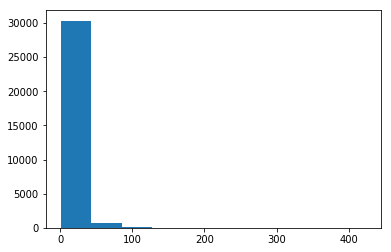

In [13]:
plt.hist(counts)
plt.show()

In [23]:
np.sum(counts < 25)

29106

In [34]:
reset_sess()